# **White Blood Cell Classification using Federated Learning**

# **Importing Dataset**

In [ ]:
! kaggle datasets download paultimothymooney/blood-cells

 97% 105M/108M [00:05<00:00, 24.3MB/s]
100% 108M/108M [00:05<00:00, 19.9MB/s]


In [ ]:
! unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [ ]:
!ls

blood-cells.zip  dataset2-master  dataset-master  kaggle.json  sample_data


# **Importing Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import matplotlib.image as mpimg
import csv
import pandas as pd
import ntpath
from datetime import datetime
import argparse
import pathlib
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset, Subset
torch.backends.cudnn.benchmark = True

In [ ]:
num_clients = 2
num_selected = (
    2 # Number of randomly selected clients from num_clients during communication round
)
num_rounds = 20
epochs = 10  # Total number of local training rounds on each selected client’s device.
batch_size = 64

In [ ]:
# Image augmentation
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10(
    "./experiments/data",
    train=True,
    download=True,
    transform=transform_train,
)
print(len(traindata))
length_dataset = 1000
indices = np.random.permutation(len(traindata))[:length_dataset]
print(len(indices))
traindata = Subset(traindata, indices)
print(len(traindata))
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    traindata, [int(length_dataset / num_clients) for _ in range(num_clients)]
)

# Creating a pytorch loader for a Deep Learning model
train_loader = [
    torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)
    for x in traindata_split
]

# Normalizing the test images
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "./experiments/data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
                ),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)
print(len(train_loader))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./experiments/data/cifar-10-python.tar.gz to ./experiments/data
50000
1000
1000
2


In [ ]:
#cuda recommended
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Image augmentation
train_dataset = torchvision.datasets.ImageFolder(
    root='dataset2-master/dataset2-master/images/TRAIN/',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

print('ttttt', len(train_dataset))
length_dataset = 9956
indices = np.random.permutation(len(train_dataset))[:length_dataset]
traindata = Subset(train_dataset, indices)

print(len(train_dataset.imgs))
print(len(traindata))
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    traindata, [int(length_dataset / num_clients) for _ in range(num_clients)]
)

# Creating a pytorch loader for a Deep Learning model
train_dataloader = [
    torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)
    for x in traindata_split
]
print('ddddddddddd', len(traindata))
test_dataset = torchvision.datasets.ImageFolder(
    root='dataset2-master/dataset2-master/images/TEST/',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

label_names = test_dataset.classes
print(label_names)
batch_size = 64
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ttttt 9957
9957
9956
ddddddddddd 9956
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
len(test_dataloader )

39

# **Training**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # Max pooling layers
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.25)
        # Fully-connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
def client_update(client_model, optimizer, loss_fn, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

"""
def server_aggregate(global_model, client_models):

    This function has aggregation method 'mean'

    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack(
            [
                client_models[i].state_dict()[k].float()
                for i in range(len(client_models))
            ],
            0,
        ).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())
"""

def server_aggregate(global_model, client_models,client_lens):
    """
    This function has aggregation method 'wmean'
    wmean takes the weighted mean of the weights of models
    """
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float()*(n*client_lens[i]/total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def test(global_model, loss_fn, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()
    test_loss = 0
    correct = 0
    true_labels = []
    pred_probs = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            probs = torch.softmax(output, dim=1)
            #correct += pred.eq(target.view_as(pred)).sum().item()
            true_labels.extend(target.tolist())
            pred_probs.extend(probs.tolist())

    test_loss /= len(test_loader.dataset)
    #acc = correct / len(test_loader.dataset)
    acc = accuracy_score(true_labels, np.argmax(pred_probs, axis=1))
    f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
    auc = roc_auc_score(true_labels, pred_probs, multi_class='ovo')
    return test_loss, acc, f1, auc, true_labels, pred_probs


In [ ]:
#### global model ##########
global_model = CNN().to(device)

############## client models ##############
client_models = [CNN().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(
        global_model.state_dict()
    )  ### initial synchronizing with global model

############### optimizers ################
opt = [optim.Adam(model.parameters()) for model in client_models]
loss_fn = [nn.CrossEntropyLoss() for model in client_models]


100%|██████████| 2/2 [03:29<00:00, 104.59s/it]


0-th round
average train loss 0.572 | test loss 0.0242 | test acc: 0.250 | f1: 0.104 | auc: 0.527


100%|██████████| 2/2 [03:18<00:00, 99.49s/it]


1-th round
average train loss 0.143 | test loss 0.00966 | test acc: 0.715 | f1: 0.717 | auc: 0.930


100%|██████████| 2/2 [03:19<00:00, 99.62s/it]


2-th round
average train loss 0.107 | test loss 0.00677 | test acc: 0.848 | f1: 0.851 | auc: 0.972


100%|██████████| 2/2 [03:19<00:00, 99.78s/it]


3-th round
average train loss 0.0626 | test loss 0.0103 | test acc: 0.859 | f1: 0.863 | auc: 0.976


100%|██████████| 2/2 [03:19<00:00, 99.93s/it] 


4-th round
average train loss 0.037 | test loss 0.0101 | test acc: 0.848 | f1: 0.851 | auc: 0.976


100%|██████████| 2/2 [03:18<00:00, 99.14s/it]


5-th round
average train loss 0.0393 | test loss 0.0117 | test acc: 0.858 | f1: 0.862 | auc: 0.976


100%|██████████| 2/2 [03:27<00:00, 103.80s/it]


6-th round
average train loss 0.0742 | test loss 0.00987 | test acc: 0.859 | f1: 0.862 | auc: 0.977


100%|██████████| 2/2 [03:19<00:00, 99.67s/it]


7-th round
average train loss 0.0208 | test loss 0.0142 | test acc: 0.857 | f1: 0.860 | auc: 0.971


100%|██████████| 2/2 [03:17<00:00, 98.81s/it]


8-th round
average train loss 0.0156 | test loss 0.0122 | test acc: 0.840 | f1: 0.844 | auc: 0.971


100%|██████████| 2/2 [03:16<00:00, 98.50s/it]


9-th round
average train loss 0.00894 | test loss 0.0108 | test acc: 0.862 | f1: 0.865 | auc: 0.976


100%|██████████| 2/2 [03:18<00:00, 99.01s/it]


10-th round
average train loss 0.0946 | test loss 0.0121 | test acc: 0.867 | f1: 0.869 | auc: 0.976


100%|██████████| 2/2 [03:18<00:00, 99.31s/it]


11-th round
average train loss 0.0176 | test loss 0.0116 | test acc: 0.852 | f1: 0.855 | auc: 0.975


100%|██████████| 2/2 [03:16<00:00, 98.33s/it]


12-th round
average train loss 0.00132 | test loss 0.0145 | test acc: 0.865 | f1: 0.869 | auc: 0.972


100%|██████████| 2/2 [03:16<00:00, 98.38s/it]


13-th round
average train loss 0.0148 | test loss 0.0134 | test acc: 0.849 | f1: 0.852 | auc: 0.975


100%|██████████| 2/2 [03:17<00:00, 98.70s/it]


14-th round
average train loss 0.00502 | test loss 0.0106 | test acc: 0.862 | f1: 0.866 | auc: 0.976


100%|██████████| 2/2 [03:17<00:00, 98.70s/it]


15-th round
average train loss 0.00335 | test loss 0.011 | test acc: 0.877 | f1: 0.880 | auc: 0.980


100%|██████████| 2/2 [03:16<00:00, 98.32s/it]


16-th round
average train loss 0.000199 | test loss 0.0148 | test acc: 0.869 | f1: 0.872 | auc: 0.974


100%|██████████| 2/2 [03:17<00:00, 98.74s/it]


17-th round
average train loss 0.00263 | test loss 0.0132 | test acc: 0.857 | f1: 0.860 | auc: 0.972


100%|██████████| 2/2 [03:16<00:00, 98.22s/it]


18-th round
average train loss 0.00708 | test loss 0.00906 | test acc: 0.871 | f1: 0.873 | auc: 0.979


100%|██████████| 2/2 [03:15<00:00, 97.97s/it]


19-th round
average train loss 0.00322 | test loss 0.0122 | test acc: 0.873 | f1: 0.875 | auc: 0.978
<class 'list'>
<class 'list'>
(2487,)
(2487, 4)
[3 3 0 ... 3 3 3]


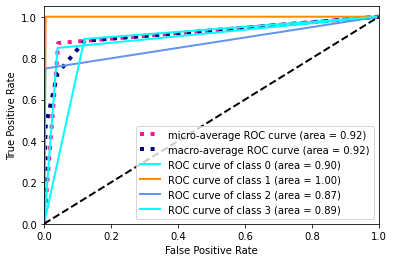

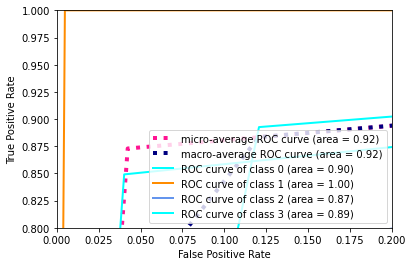

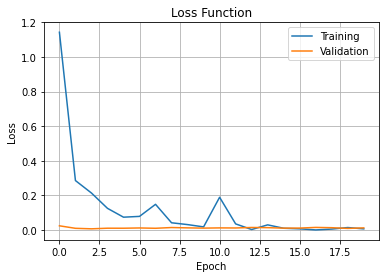

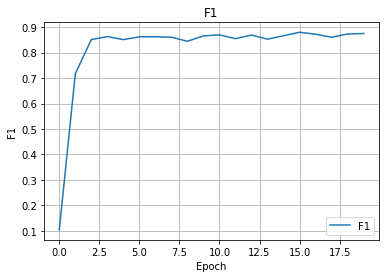

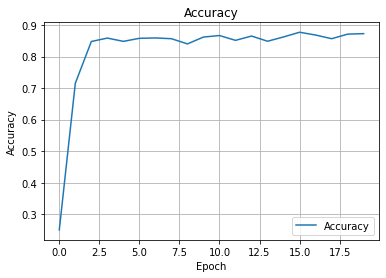

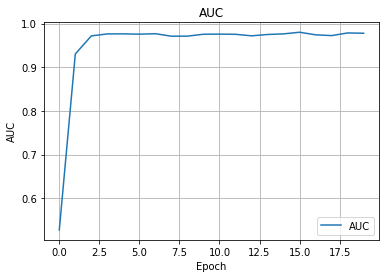

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.88      0.85      0.86       623
  LYMPHOCYTE       0.99      1.00      0.99       620
    MONOCYTE       0.99      0.75      0.85       620
  NEUTROPHIL       0.71      0.89      0.79       624

    accuracy                           0.87      2487
   macro avg       0.89      0.87      0.87      2487
weighted avg       0.89      0.87      0.87      2487



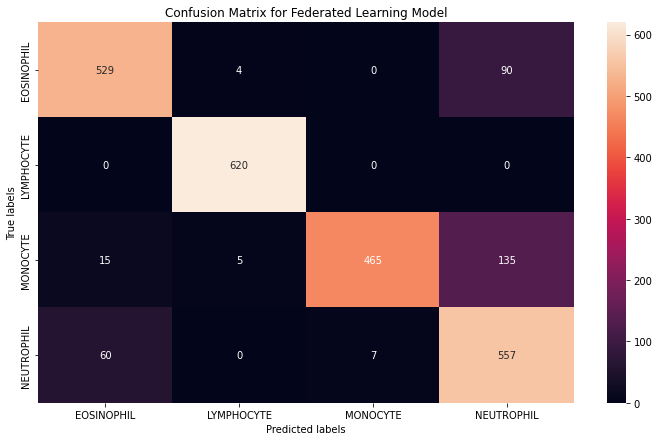

In [ ]:
losses_train = []
losses_test = []
acc_train = []
acc_test = []
f1_test = []
auc_test = []

# Runnining FL
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    client_lens = [len(train_loader[idx]) for idx in client_idx]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], loss_fn[i], train_dataloader[client_idx[i]], epoch=epochs)
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models, client_lens)
    loss_test = nn.CrossEntropyLoss()
    test_loss, acc, f1, auc, true_labels, pred_probs = test(global_model, loss_test, test_dataloader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    f1_test.append(f1)
    auc_test.append(auc)
    print("%d-th round" % r)
    print(
        "average train loss %0.3g | test loss %0.3g | test acc: %0.3f | f1: %0.3f | auc: %0.3f"
        % (loss / num_selected, test_loss, acc, f1, auc)
    )

classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
clr = classification_report(true_labels, np.argmax(pred_probs, axis=1), target_names=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
print(type(true_labels))
print(type(pred_probs))
print(np.shape(true_labels))
print(np.shape(pred_probs))
print(np.argmax(pred_probs, axis = 1))


from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(true_labels)
true_labels_plot = lb.transform(true_labels)
pred_probs_plot = lb.transform(np.argmax(pred_probs, axis = 1))

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(true_labels_plot[:, i], pred_probs_plot[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(true_labels_plot.ravel(), pred_probs_plot.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



plt.plot(losses_train)
plt.plot(losses_test)
plt.title('Loss Function')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(f1_test)
plt.title('F1')
plt.legend(['F1'])
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()

plt.plot(acc_test)
plt.title('Accuracy')
plt.legend(['Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

plt.plot(auc_test)
plt.title('AUC')
plt.legend(['AUC'])
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid()
plt.show()

# Build confusion matrix
plt.figure(figsize = (12,7))
ax = plt.subplot()
cf_matrix = confusion_matrix(true_labels, np.argmax(pred_probs, axis=1))
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],columns = [i for i in classes])
sns.heatmap(cf_matrix, annot=True, fmt="g", ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Federated Learning Model')
ax.xaxis.set_ticklabels(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
ax.yaxis.set_ticklabels(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])

print("Classification Report:\n-----------------------------\n", clr)

In [ ]:
train_main= "dataset-master/dataset-master/JPEGImages/"
train_path = "dataset2-master/dataset2-master/images/TRAIN/"
val_path = "dataset2-master/dataset2-master/images/TEST/"
test_path = "dataset2-master/dataset2-master/images/TEST_SIMPLE/"
CSV = pd.read_csv("dataset2-master/dataset2-master/labels.csv")
LABELS = os.listdir(train_path)

In [ ]:
print(len(test_path))

51


In [ ]:
print(LABELS)

['NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL', 'MONOCYTE']


In [ ]:
if not os.path.exists('HSV_IMAGES/TRAIN/EOSINOPHIL'):
  os.makedirs('HSV_IMAGES/TRAIN/EOSINOPHIL')
SAVE_DIR = 'HSV_IMAGES/TRAIN/EOSINOPHIL'
if not os.path.exists('HSV_IMAGES/TRAIN/LYMPHOCYTE'):
  os.makedirs('HSV_IMAGES/TRAIN/LYMPHOCYTE')
SAVE_DIR = 'HSV_IMAGES/TRAIN/LYMPHOCYTE'
if not os.path.exists('HSV_IMAGES/TRAIN/MONOCYTE'):
  os.makedirs('HSV_IMAGES/TRAIN/MONOCYTE')
SAVE_DIR = 'HSV_IMAGES/TRAIN/MONOCYTE'
if not os.path.exists('HSV_IMAGES/TRAIN/NEUTROPHIL'):
  os.makedirs('HSV_IMAGES/TRAIN/NEUTROPHIL')
SAVE_DIR = 'HSV_IMAGES/TRAIN/NEUTROPHIL'

In [ ]:
if not os.path.exists('HSV_IMAGES/TEST/EOSINOPHIL'):
  os.makedirs('HSV_IMAGES/TEST/EOSINOPHIL')
SAVE_DIR = 'HSV_IMAGES/TEST/EOSINOPHIL'
if not os.path.exists('HSV_IMAGES/TEST/LYMPHOCYTE'):
  os.makedirs('HSV_IMAGES/TEST/LYMPHOCYTE')
SAVE_DIR = 'HSV_IMAGES/TEST/LYMPHOCYTE'
if not os.path.exists('HSV_IMAGES/TEST/MONOCYTE'):
  os.makedirs('HSV_IMAGES/TEST/MONOCYTE')
SAVE_DIR = 'HSV_IMAGES/TEST/MONOCYTE'
if not os.path.exists('HSV_IMAGES/TEST/NEUTROPHIL'):
  os.makedirs('HSV_IMAGES/TEST/NEUTROPHIL')
SAVE_DIR = 'HSV_IMAGES/TEST/NEUTROPHIL'

In [ ]:
train_path_hsv = "HSV_IMAGES/TRAIN"
test_path_hsv = "HSV_IMAGES/TEST"

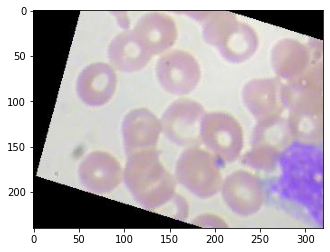

In [ ]:
for category in LABELS:
    path = os.path.join(train_path, category)
    for img in os.listdir(path):
        #print(path)
        #print(img)
        img_array = cv2.imread(os.path.join(path,img))
        img_array1 = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = cv2.cvtColor(img_array1, cv2.COLOR_RGB2HSV)
        hue = img_array[:,:,1]
        #print(category)
        plt.imshow(img_array1)
        cat = str(category)
        #print(train_path_hsv)
        save_path = train_path_hsv + '/'+ cat+ '/'+ img
        #print(save_path)
        plt.imsave(save_path, hue)
        #plt.show()

In [ ]:
for category in LABELS:
    path = os.path.join(val_path, category)
    for img in os.listdir(path):
        #print(path)
        #print(img)
        img_array = cv2.imread(os.path.join(path,img))
        img_array1 = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = cv2.cvtColor(img_array1, cv2.COLOR_RGB2HSV)
        hue = img_array[:,:,1]
        #print(category)
        #plt.imshow(hue, cmap = 'hsv')
        cat = str(category)
        #print(train_path_hsv)
        save_path = test_path_hsv + '/'+ cat+ '/'+ img
        #print(save_path)
        plt.imsave(save_path, hue)
        #plt.show()

In [ ]:
num_clients = 2
num_selected = (
    2 # Number of randomly selected clients from num_clients during communication round
)
num_rounds = 20
epochs = 10  # Total number of local training rounds on each selected client’s device.
batch_size = 64

# **Validation**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import matplotlib.image as mpimg
import csv
import pandas as pd
import ntpath
from datetime import datetime
import argparse
import torchvision.datasets as Dataset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

In [ ]:
# Image augmentation
train_dataset = torchvision.datasets.ImageFolder(
    root='dataset2-master/dataset2-master/images/TRAIN/',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

print('ttttt', len(train_dataset))
length_dataset = 9956
indices = np.random.permutation(len(train_dataset))[:length_dataset]
traindata = Subset(train_dataset, indices)

print(len(train_dataset.imgs))
print(len(traindata))
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    traindata, [int(length_dataset / num_clients) for _ in range(num_clients)]
)

# Creating a pytorch loader for a Deep Learning model
train_dataloader = [
    torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)
    for x in traindata_split
]
print('ddddddddddd', len(traindata))
test_dataset = torchvision.datasets.ImageFolder(
    root='dataset2-master/dataset2-master/images/TEST/',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

label_names = test_dataset.classes
print(label_names)
batch_size = 64
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ttttt 9957
9957
9956
ddddddddddd 9956
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
train_path_hsv = "HSV_IMAGES/TRAIN"
test_path_hsv = "HSV_IMAGES/TEST"

train_dataset = torchvision.datasets.ImageFolder(
    root='HSV_IMAGES/TRAIN',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

print('ttttt', len(train_dataset))
length_dataset = 9956
indices = np.random.permutation(len(train_dataset))[:length_dataset]
traindata = Subset(train_dataset, indices)


print('aaaaaaaaaaaaaaaaaaa', len(train_dataset))

print(len(train_dataset.imgs))
print(len(traindata))
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    traindata, [int(length_dataset / num_clients) for _ in range(num_clients)]
)

# Creating a pytorch loader for a Deep Learning model
train_loader = [
    torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)
    for x in traindata_split
]
print('ddddddddddd', len(traindata))
test_dataset = torchvision.datasets.ImageFolder(
    root="HSV_IMAGES/TEST",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

label_names = test_dataset.classes
print(label_names)
batch_size = 64
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ttttt 9957
aaaaaaaaaaaaaaaaaaa 9957
9957
9956
ddddddddddd 9956
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
len(test_loader )

39

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # Max pooling layers
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.25)
        # Fully-connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
def client_update(client_model, optimizer, loss_fn, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

"""
def server_aggregate(global_model, client_models):

    This function has aggregation method 'mean'

    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack(
            [
                client_models[i].state_dict()[k].float()
                for i in range(len(client_models))
            ],
            0,
        ).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())
"""

def server_aggregate(global_model, client_models,client_lens):
    """
    This function has aggregation method 'wmean'
    wmean takes the weighted mean of the weights of models
    """
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float()*(n*client_lens[i]/total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def test(global_model, loss_fn, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()
    test_loss = 0
    correct = 0
    true_labels = []
    pred_probs = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            probs = torch.softmax(output, dim=1)
            #correct += pred.eq(target.view_as(pred)).sum().item()
            true_labels.extend(target.tolist())
            pred_probs.extend(probs.tolist())

    test_loss /= len(test_loader.dataset)
    #acc = correct / len(test_loader.dataset)
    acc = accuracy_score(true_labels, np.argmax(pred_probs, axis=1))
    f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
    auc = roc_auc_score(true_labels, pred_probs, multi_class='ovo')
    return test_loss, acc, f1, auc, true_labels, pred_probs


In [ ]:
#### global model ##########
global_model = CNN().to(device)

############## client models ##############
client_models = [CNN().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(
        global_model.state_dict()
    )  ### initial synchronizing with global model

############### optimizers ################
opt = [optim.Adam(model.parameters()) for model in client_models]
loss_fn = [nn.CrossEntropyLoss() for model in client_models]


100%|██████████| 2/2 [03:13<00:00, 96.60s/it]


0-th round
average train loss 0.419 | test loss 0.0263 | test acc: 0.251 | f1: 0.100 | auc: 0.495


100%|██████████| 2/2 [03:04<00:00, 92.12s/it]


1-th round
average train loss 0.222 | test loss 0.0189 | test acc: 0.496 | f1: 0.485 | auc: 0.810


100%|██████████| 2/2 [03:05<00:00, 92.81s/it]


2-th round
average train loss 0.121 | test loss 0.0243 | test acc: 0.612 | f1: 0.598 | auc: 0.870


100%|██████████| 2/2 [03:06<00:00, 93.42s/it]


3-th round
average train loss 0.0704 | test loss 0.0246 | test acc: 0.692 | f1: 0.689 | auc: 0.886


100%|██████████| 2/2 [03:11<00:00, 95.72s/it]


4-th round
average train loss 0.0354 | test loss 0.0236 | test acc: 0.695 | f1: 0.692 | auc: 0.901


100%|██████████| 2/2 [03:07<00:00, 93.53s/it]


5-th round
average train loss 0.0109 | test loss 0.0263 | test acc: 0.677 | f1: 0.675 | auc: 0.894


100%|██████████| 2/2 [03:04<00:00, 92.14s/it]


6-th round
average train loss 0.0296 | test loss 0.0288 | test acc: 0.686 | f1: 0.683 | auc: 0.897


100%|██████████| 2/2 [03:02<00:00, 91.40s/it]


7-th round
average train loss 0.0309 | test loss 0.026 | test acc: 0.679 | f1: 0.672 | auc: 0.881


100%|██████████| 2/2 [03:04<00:00, 92.14s/it]


8-th round
average train loss 0.0126 | test loss 0.0259 | test acc: 0.700 | f1: 0.694 | auc: 0.903


100%|██████████| 2/2 [03:05<00:00, 92.53s/it]


9-th round
average train loss 0.00504 | test loss 0.0273 | test acc: 0.703 | f1: 0.698 | auc: 0.900


100%|██████████| 2/2 [03:05<00:00, 92.54s/it]


10-th round
average train loss 0.0328 | test loss 0.0252 | test acc: 0.700 | f1: 0.695 | auc: 0.908


100%|██████████| 2/2 [03:05<00:00, 92.93s/it]


11-th round
average train loss 0.00353 | test loss 0.0273 | test acc: 0.718 | f1: 0.712 | auc: 0.908


100%|██████████| 2/2 [03:05<00:00, 92.80s/it]


12-th round
average train loss 0.00185 | test loss 0.0269 | test acc: 0.691 | f1: 0.686 | auc: 0.890


100%|██████████| 2/2 [03:04<00:00, 92.46s/it]


13-th round
average train loss 0.00665 | test loss 0.0296 | test acc: 0.701 | f1: 0.700 | auc: 0.891


100%|██████████| 2/2 [03:05<00:00, 92.75s/it]


14-th round
average train loss 0.00337 | test loss 0.028 | test acc: 0.701 | f1: 0.698 | auc: 0.899


100%|██████████| 2/2 [03:04<00:00, 92.29s/it]


15-th round
average train loss 0.00681 | test loss 0.0298 | test acc: 0.696 | f1: 0.688 | auc: 0.887


100%|██████████| 2/2 [03:03<00:00, 91.94s/it]


16-th round
average train loss 0.0437 | test loss 0.0248 | test acc: 0.711 | f1: 0.707 | auc: 0.912


100%|██████████| 2/2 [03:03<00:00, 91.71s/it]


17-th round
average train loss 0.0141 | test loss 0.0232 | test acc: 0.698 | f1: 0.696 | auc: 0.898


100%|██████████| 2/2 [03:05<00:00, 92.60s/it]


18-th round
average train loss 0.000355 | test loss 0.0278 | test acc: 0.712 | f1: 0.709 | auc: 0.911


100%|██████████| 2/2 [03:03<00:00, 91.89s/it]


19-th round
average train loss 0.0139 | test loss 0.0267 | test acc: 0.712 | f1: 0.708 | auc: 0.907
<class 'list'>
<class 'list'>
(2487,)
(2487, 4)
[3 1 2 ... 1 3 3]


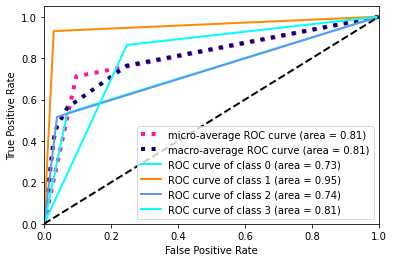

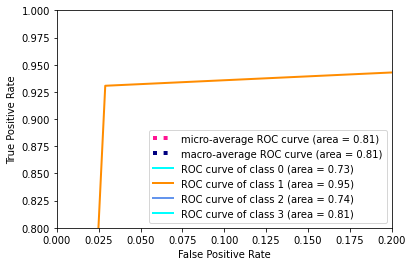

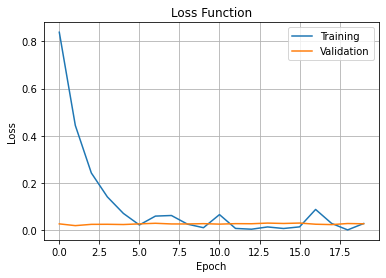

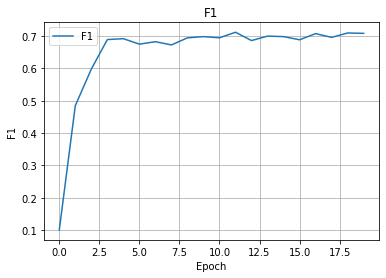

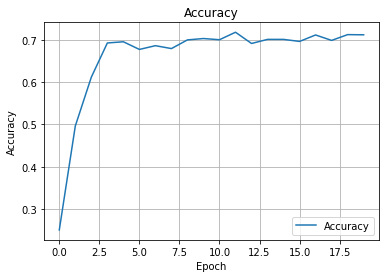

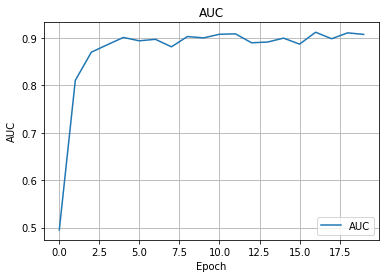

Classification Report:
-----------------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.72      0.54      0.61       623
  LYMPHOCYTE       0.91      0.93      0.92       620
    MONOCYTE       0.82      0.52      0.63       620
  NEUTROPHIL       0.54      0.86      0.66       624

    accuracy                           0.71      2487
   macro avg       0.75      0.71      0.71      2487
weighted avg       0.75      0.71      0.71      2487



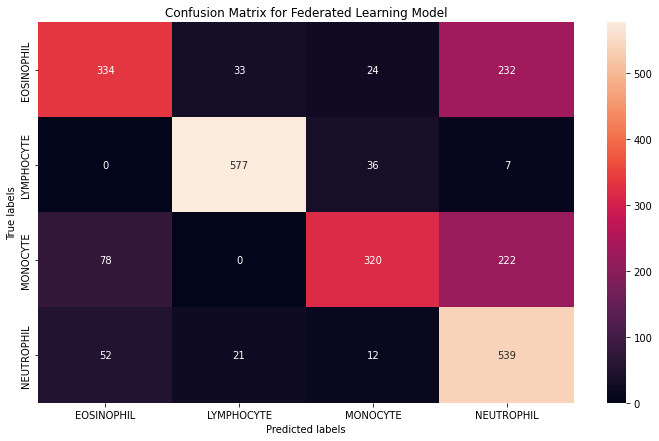

In [ ]:
losses_train = []
losses_test = []
acc_train = []
acc_test = []
f1_test = []
auc_test = []

# Runnining FL
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    client_lens = [len(train_loader[idx]) for idx in client_idx]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], loss_fn[i], train_loader[client_idx[i]], epoch=epochs)
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models, client_lens)
    loss_test = nn.CrossEntropyLoss()
    test_loss, acc, f1, auc, true_labels, pred_probs = test(global_model, loss_test, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    f1_test.append(f1)
    auc_test.append(auc)
    print("%d-th round" % r)
    print(
        "average train loss %0.3g | test loss %0.3g | test acc: %0.3f | f1: %0.3f | auc: %0.3f"
        % (loss / num_selected, test_loss, acc, f1, auc)
    )

classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
clr = classification_report(true_labels, np.argmax(pred_probs, axis=1), target_names=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
print(type(true_labels))
print(type(pred_probs))
print(np.shape(true_labels))
print(np.shape(pred_probs))
print(np.argmax(pred_probs, axis = 1))


from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(true_labels)
true_labels_plot = lb.transform(true_labels)
pred_probs_plot = lb.transform(np.argmax(pred_probs, axis = 1))

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = metrics.roc_curve(true_labels_plot[:, i], pred_probs_plot[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(true_labels_plot.ravel(), pred_probs_plot.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



plt.plot(losses_train)
plt.plot(losses_test)
plt.title('Loss Function')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(f1_test)
plt.title('F1')
plt.legend(['F1'])
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()

plt.plot(acc_test)
plt.title('Accuracy')
plt.legend(['Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

plt.plot(auc_test)
plt.title('AUC')
plt.legend(['AUC'])
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid()
plt.show()

# Build confusion matrix
plt.figure(figsize = (12,7))
ax = plt.subplot()
cf_matrix = confusion_matrix(true_labels, np.argmax(pred_probs, axis=1))
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],columns = [i for i in classes])
sns.heatmap(cf_matrix, annot=True, fmt="g", ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Federated Learning Model')
ax.xaxis.set_ticklabels(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
ax.yaxis.set_ticklabels(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])

print("Classification Report:\n-----------------------------\n", clr)